In [1]:
import pandas as pd
import numpy as np

from numpy import random as rd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ito_diffusion_multi_d import *
from lasso import *
from synthetic_asset_gen import Return_Normal_Gen
from corr_matrix import random_corr_matrix_from_factors

plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': (11,7),
}
plt.rcParams.update(params)

In [3]:
n_steps = 300
n = 100
T = 1
n_epochs = int(5e3)
learning_rate = 0.01

# Number of correlation factors,
# the lower this number, the sparser the replication can be. 
# Indeed, this means the market is driven by a few factors and all
# observable assets are just combinations of these factors.
n_factors = 20

ONE_PCT = 1e-2
# number of business days in a year (for scaling)
DAYS_IN_YEAR = 252

# Generate artificial prices and returns paths

In [4]:
def generate_data(corr_matrix=None,
                  vol=None,
                  drift=None,
                  n_steps=n_steps,
                 ):
    """Generate synthetic price series from Brownian sampling.
    """
    gen = Return_Normal_Gen(corr_matrix=corr_matrix,
                            vol=vol,
                            drift=drift,
                            n_steps=n_steps,
                           )
    # returns
    rets = gen.gen_rets()
    
    # individual returns
    data_raw = np.array(rets)
    # returns of a equiweighhted portfolio
    target_raw = np.array(rets).sum(axis=1).reshape(-1, 1) / n 

    scaler_data = StandardScaler()
    scaler_target = StandardScaler()
    data = scaler_data.fit_transform(data_raw)
    target = scaler_target.fit_transform(target_raw)    
    
    gen.plot()
    
    return data, target, data_raw, target_raw

## Train wrapper

In [5]:
def train(data, 
          target,
          data_raw,
          target_raw,
          l1_strength=0.0, 
          active_features_threshold=0.01,
         ):
    model = Lasso()
    model.X = data
    model.y = target
    model.n_epochs = n_epochs
    model.verbose = False
    model.l1_strength = l1_strength
    model.optim_params = {
        'optimizer_name': 'adam',
        'learning_rate': learning_rate,
    }
    model.active_features_threshold = active_features_threshold
    
    # Train
    model.fit()
    
    # Visualize the replication portfolio weights
    model.bar_plot()
    
    # Rescale and compute the sparse regression line    
    scaler_target = StandardScaler()
    scaler_target.fit(target_raw)
    y_fit = scaler_target.inverse_transform(np.matmul(data, model.theta_filtered))
    print('L2 tracking error: {:.2f}'.format(np.linalg.norm(y_fit-target_raw.flatten())))

    return model

## Generate artificial asset price paths

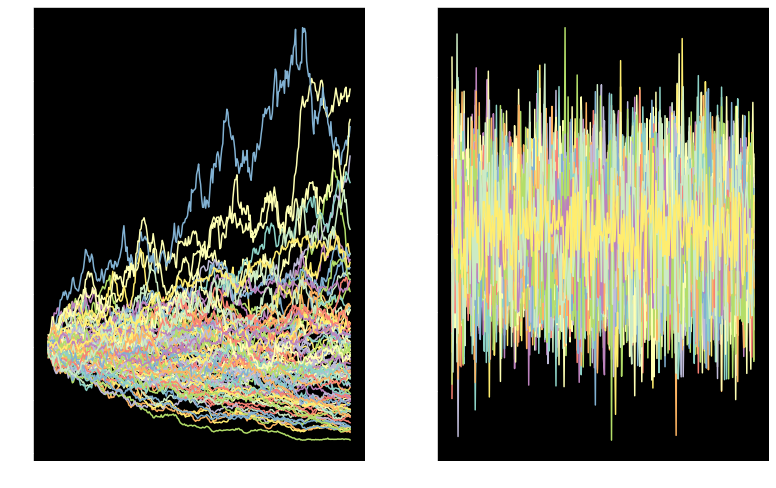

In [6]:
corr_matrix = random_corr_matrix_from_factors(n=n, n_factors=n_factors, eps=0.0)

vol_lo = 20*ONE_PCT/np.sqrt(DAYS_IN_YEAR)
vol_hi = 60*ONE_PCT/np.sqrt(DAYS_IN_YEAR)

drift_lo = -10*ONE_PCT/DAYS_IN_YEAR
drift_hi = 10*ONE_PCT/DAYS_IN_YEAR

vol = rd.uniform(vol_lo, vol_hi, n)
drift = rd.normal(drift_lo, drift_hi, n)
data, target, data_raw, target_raw = generate_data(corr_matrix, vol, drift)

In [7]:
pd.DataFrame(corr_matrix).style.background_gradient()

### Weak regularization


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



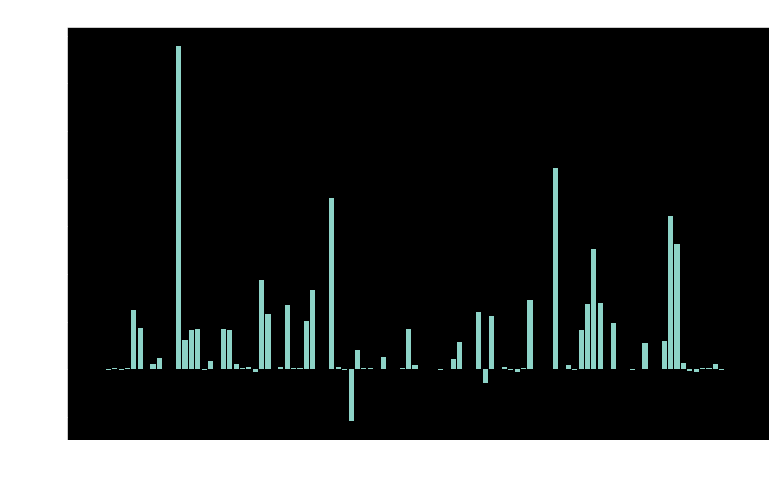

L2 tracking error: 0.02


In [8]:
model = train(data,
              target, 
              data_raw, 
              target_raw, 
              l1_strength=0.01,
              active_features_threshold=0.1
             )

### Strong regularization

Sparser, larger tracking error

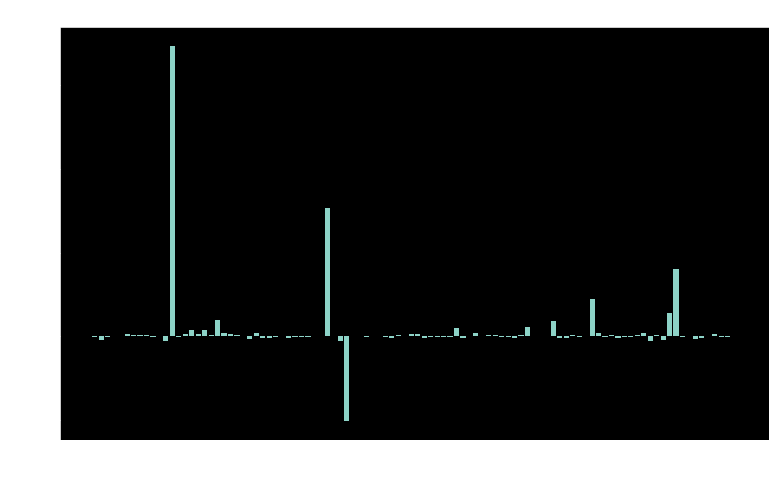

L2 tracking error: 0.03


In [9]:
model = train(data,
              target, 
              data_raw, 
              target_raw, 
              l1_strength=0.5,
              active_features_threshold=0.1
             )

### Lasso path

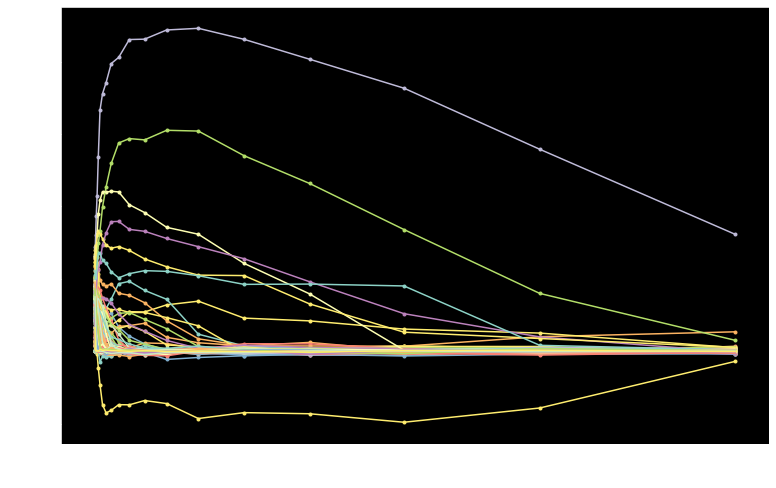

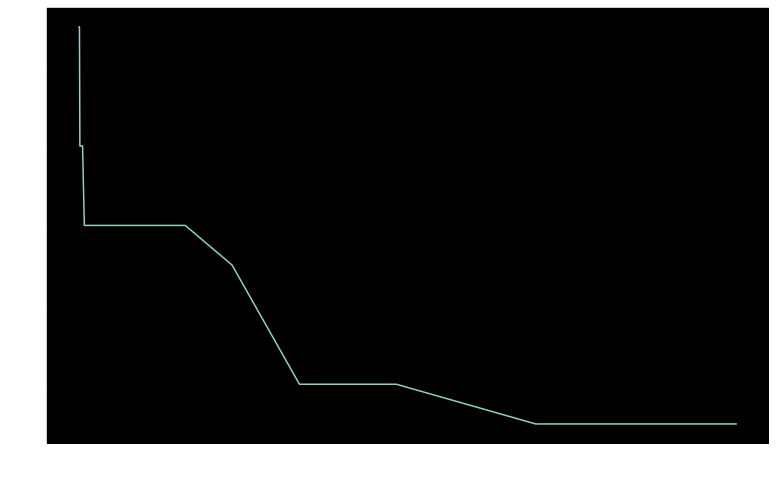

In [10]:
path, active_features_path, grid = model.lasso_path(n_l1_strength=20,
                                                    l1_min=0.001,
                                                    l1_max=1.0,
                                                    plot_path=True,
                                                    plot_active_features_path=True,
                                                    add_legend=False,
                                                   )